# Formation Energy Prediction using *Meredig 2014* Descriptors

This notebook uses the method from [Meredig 2014](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.094104) to predict formation energy of compounds. Specifically, it uses the set of composition based attributes described in the paper to train a machine learning model.

In [1]:
training_files = ["datasets/meredig_binary_hull.data", "datasets/meredig_stable_ternary.data"]
delimiters = [' ',' ']

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from matminer.featurizers.data import MagpieData
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load input files and generate descriptors
The training set is a set of ~4500 compounds with data originally from the Inorganic Crystal Structures Database (ICSD).

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
    
    training_set = pd.DataFrame()
    
    for i in range(len(files)):
        training_set = pd.read_csv(files[i], sep=sep[i])
        
    return training_set

training_set = load_training_set(training_files, delimiters)

### Create PyMatGen Composition objects
The MatMiner featurizer takes PyMatGen composition objects as inputs

In [4]:
comp_objects = [Composition(comp) for comp in training_set["composition"]]
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,composition,delta_e,comp_obj
0,P1Pt1Tm1,-1.415275,"(Tm, Pt, P)"
1,Li1N1Zn1,-0.337226,"(Li, Zn, N)"
2,P1Pt1Tb1,-1.224506,"(Tb, Pt, P)"
3,Au1Si1Th1,-0.775884,"(Th, Si, Au)"
4,As1Li1Mg1,-0.755550,"(As, Li, Mg)"
5,Pd1Sb1Sc1,-1.047253,"(Sb, Sc, Pd)"
6,As1Ba1Li1,-0.948120,"(Ba, As, Li)"
7,As1Li1Zn1,-0.527295,"(As, Li, Zn)"
8,P1Pt1Y1,-1.442090,"(P, Pt, Y)"
9,Hf1Pd1Sn1,-0.751732,"(Hf, Sn, Pd)"


## Compute descriptors using MatMiner
Here, we compute composition based attributes as described in *Meredig 2014* using the [MatMiner](https://github.com/hackingmaterials/matminer) implementation of the featurizer.

In [5]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    training_set_updated = cp.ElementFraction().featurize_dataframe(training_set, col_id="comp_obj")
    training_set_updated = cp.ElementProperty(method=None, stats=["mean"], attributes=["AtomicWeight","Column","Row"], data_source=MagpieData()).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ElementProperty(method=None, stats=["mean","range"], attributes=["Number","CovalentRadius","Electronegativity"], data_source=MagpieData()).featurize_dataframe(training_set_updated, col_id="comp_obj")
    training_set_updated = cp.ValenceOrbital(orbitals=["s","p","d","f"], props=["avg","frac"]).featurize_dataframe(training_set_updated, col_id="comp_obj")
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)
all_descriptors

CPU times: user 9.42 s, sys: 142 ms, total: 9.57 s
Wall time: 9.96 s


## Predicting formation energy
First, drop rows that contain NaN values

In [6]:
training_set_use = all_descriptors.dropna()
training_set_use

,composition,delta_e,comp_obj,Ac,Ag,Al,Am,Ar,As,At,...,range Electronegativity,range Number,avg d valence electrons,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons
0,P1Pt1Tm1,-1.415275,"(Tm, Pt, P)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.03,63.0,3.000000,9.000000,1.000000,1.666667,0.204545,0.613636,0.068182,0.113636
1,Li1N1Zn1,-0.337226,"(Li, Zn, N)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,2.06,27.0,3.333333,0.000000,1.000000,1.666667,0.555556,0.000000,0.166667,0.277778
2,P1Pt1Tb1,-1.224506,"(Tb, Pt, P)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.07,63.0,3.000000,7.666667,1.000000,1.666667,0.225000,0.575000,0.075000,0.125000
3,Au1Si1Th1,-0.775884,"(Th, Si, Au)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.24,76.0,4.000000,4.666667,0.666667,1.666667,0.363636,0.424242,0.060606,0.151515
4,As1Li1Mg1,-0.755550,"(As, Li, Mg)",0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,...,1.20,30.0,3.333333,0.000000,1.000000,1.666667,0.555556,0.000000,0.166667,0.277778
5,Pd1Sb1Sc1,-1.047253,"(Sb, Sc, Pd)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.84,30.0,7.000000,0.000000,1.000000,1.333333,0.750000,0.000000,0.107143,0.142857
6,As1Ba1Li1,-0.948120,"(Ba, As, Li)",0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,...,1.29,53.0,3.333333,0.000000,1.000000,1.666667,0.555556,0.000000,0.166667,0.277778
7,As1Li1Zn1,-0.527295,"(As, Li, Zn)",0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,...,1.20,30.0,6.666667,0.000000,1.000000,1.666667,0.714286,0.000000,0.107143,0.178571
8,P1Pt1Y1,-1.442090,"(P, Pt, Y)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.06,63.0,3.333333,4.666667,1.000000,1.666667,0.312500,0.437500,0.093750,0.156250
9,Hf1Pd1Sn1,-0.751732,"(Hf, Sn, Pd)",0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.90,26.0,7.333333,4.666667,0.666667,1.333333,0.523810,0.333333,0.047619,0.095238


### Predict formation energy range using a Random Forest Classifier

In [7]:
#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['n' 'n' 'n' ..., 'n' 'n' 'n']


In [8]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [9]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,10702,0
p,1,5


### Predicting formation energy values using Random Forest Regression

In [10]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
prediction = rf_model.predict(training_set_use[attr_names])

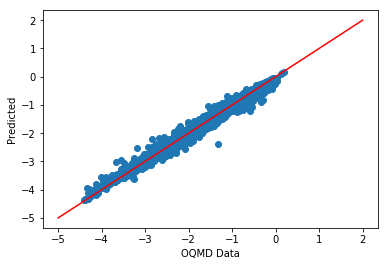

In [12]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Compute mean absolute cross-validation error

In [13]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.122513493771
CPU times: user 15.9 s, sys: 175 ms, total: 16.1 s
Wall time: 16.3 s


## Predict formation energies of another set of ternary compounds

In [14]:
#Load prediction set and calculate attributes

prediction_set = pd.read_csv("datasets/meredig_prediction_set.csv", sep=" ")
comp_objects = [Composition(comp) for comp in prediction_set["composition"]]
prediction_set = prediction_set.assign(comp_obj=comp_objects)

ps_descriptors, ps_attr_names = calc_attributes(prediction_set)

ps_descriptors

,composition,current_knownFE,ML_stability,heuristic_stability,comp_obj,Ac,Ag,Al,Am,Ar,...,range Electronegativity,range Number,avg d valence electrons,avg f valence electrons,avg p valence electrons,avg s valence electrons,frac d valence electrons,frac f valence electrons,frac p valence electrons,frac s valence electrons
0,F5Si1Yb3,-2.315326,0.788656,1.104844,"(F, Yb, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.720,61.0,0.000000,4.666667,3.000000,2.000000,0.000000,0.482759,0.310345,0.206897
1,O4P1.33333333U1,-2.510609,0.989140,0.949985,"(O, U, P)",0.000000,0.0,0.0,0.0,0.0,...,2.060,84.0,0.157895,0.473684,3.157895,2.000000,0.027273,0.081818,0.545455,0.345455
2,O8Si1Pa5,-2.861381,0.720226,1.060872,"(O, Pa, Si)",0.000000,0.0,0.0,0.0,0.0,...,1.940,83.0,0.357143,0.714286,2.428571,2.000000,0.064935,0.129870,0.441558,0.363636
3,F5S1.5V1,-2.105698,0.770123,0.986644,"(S, F, V)",0.000000,0.0,0.0,0.0,0.0,...,2.350,14.0,0.400000,0.000000,4.133333,2.000000,0.061224,0.000000,0.632653,0.306122
4,F9V3Yb1,-2.665806,0.701196,1.028361,"(F, Yb, V)",0.000000,0.0,0.0,0.0,0.0,...,2.720,61.0,0.692308,1.076923,3.461538,2.000000,0.095745,0.148936,0.478723,0.276596
5,O4P1.33333333Pa1,-2.422391,1.124232,0.735729,"(O, Pa, P)",0.000000,0.0,0.0,0.0,0.0,...,1.940,83.0,0.157895,0.315789,3.157895,2.000000,0.028037,0.056075,0.560748,0.355140
6,F5S1.5Mn1,-1.763971,1.066721,0.738074,"(S, Mn, F)",0.000000,0.0,0.0,0.0,0.0,...,2.430,16.0,0.666667,0.000000,4.133333,2.000000,0.098039,0.000000,0.607843,0.294118
7,O2Si1U2,-2.202354,0.747492,0.823106,"(O, U, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.060,84.0,0.400000,1.200000,2.000000,2.000000,0.071429,0.214286,0.357143,0.357143
8,F2Si1Pa1.5,-2.098935,0.726589,0.829021,"(F, Pa, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.480,82.0,0.333333,0.666667,2.666667,2.000000,0.058824,0.117647,0.470588,0.352941
9,O2Si1Np2,-2.354734,0.725948,0.808873,"(O, Np, Si)",0.000000,0.0,0.0,0.0,0.0,...,2.080,85.0,0.400000,1.600000,2.000000,2.000000,0.066667,0.266667,0.333333,0.333333


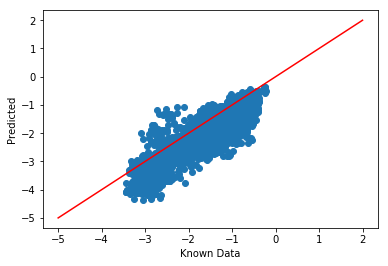

In [15]:
ps_prediction = rf_model.predict(ps_descriptors[attr_names])
plt.scatter(prediction_set["current_knownFE"], ps_prediction)
plt.plot(range(-5,3), range(-5,3), 'r')
plt.xlabel("Known Data")
plt.ylabel("Predicted")

In [16]:
mae = np.mean(np.abs(prediction_set["current_knownFE"] - ps_prediction))
print mae

0.466508129919
